<a href="https://colab.research.google.com/github/osaeed-ds/FieldLearnings/blob/main/Image_Search_on_Astra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/difli/astra-vsearch-image/blob/main/astra-vsearch-image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Search using OpenAI Clip powered by Astra Vector Search
Jupyter notebook for image search powered by [Astra Vector Search](https://docs.datastax.com/en/astra-serverless/docs/vector-search/overview.html) and OpenAI [CLIP Model](https://github.com/openai/CLIP).

## OpenAI CLIP Model
CLIP, or "Contrastive Language-Image Pretraining", is an artificial intelligence model developed by OpenAI. The model is trained to understand and associate images with natural language by using a vast number of images and their associated textual descriptions. CLIP can perform tasks such as generating textual descriptions of images or finding images based on given text.

## Astra Vector Search
Astra vector search enables developers to search a database by context or meaning rather than keywords or literal values. This is done by using “embeddings”. Embeddings are a type of representation used in machine learning where high-dimensional or complex data is mapped onto vectors in a lower-dimensional space. These vectors capture the semantic properties of the input data, meaning that similar data points have similar embeddings.

## Demo Summary
The demo showcases the CLIP model, which generates embeddings for images. These embeddings, along with metadata, are stored in Astra DB. Specifically, the embeddings are stored in a column of type Vector. The goal of the demo is to utilize Astra Vector Search to find an image of a house with a swimming pool. The CLIP model generates embeddings based on the search string 'a house with a swimming pool'. These embeddings are then used in a query to find an image that shares similar embeddings with the search string, ultimately displaying an image of a house with a swimming pool.



# Getting Started with this notebook
1. Create a new ***vector search enabled database*** in [Astra](https://astra.datastax.com/).
   1. Create a keyspace
   2. Create a token with permissions to create tables
   3. Download your secure-connect-bundle.zip file.

# Setup

In [ ]:
!pip install datasets cassandra-driver matplotlib sentence-transformers

# Imports

In [ ]:
import os

from cassandra.cluster import Cluster
from cassandra.auth import PlainTextAuthProvider

from PIL import Image
from sentence_transformers import SentenceTransformer
from matplotlib import pyplot as plt
from matplotlib import image as mpimg

# Environment Variables

In [ ]:
import os
from getpass import getpass

try:
    from google.colab import files
    IS_COLAB = True
except ModuleNotFoundError:
    IS_COLAB = False

In [ ]:
# Your database's Secure Connect Bundle zip file is needed:
if IS_COLAB:
    print('Please upload your Secure Connect Bundle zipfile: ')
    uploaded = files.upload()
    if uploaded:
        astraBundleFileTitle = list(uploaded.keys())[0]
        ASTRA_DB_SECURE_BUNDLE_PATH = os.path.join(os.getcwd(), astraBundleFileTitle)
    else:
        raise ValueError(
            'Cannot proceed without Secure Connect Bundle. Please re-run the cell.'
        )
else:
    # you are running a local-jupyter notebook:
    ASTRA_DB_SECURE_BUNDLE_PATH = input("Please provide the full path to your Secure Connect Bundle zipfile: ")

ASTRA_DB_APPLICATION_TOKEN = getpass("Please provide your Database Token ('AstraCS:...' string): ")
ASTRA_DB_KEYSPACE = input("Please provide the Keyspace name for your Database: ")
ASTRA_DB_TABLE = input("Please provide the name for you the table to be created (e.g. images): ")

Please upload your Secure Connect Bundle zipfile: 


Saving secure-connect-yt-transcriptions-demo.zip to secure-connect-yt-transcriptions-demo.zip
Please provide your Database Token ('AstraCS:...' string): ··········
Please provide the Keyspace name for your Database: cassio_tutorials
Please provide the name for you the table to be created: images


# Connect to Astra DB

In [ ]:
# Don't mind the "Closing connection" error after "downgrading protocol..." messages,
# it is really just a warning: the connection will work smoothly.
cluster = Cluster(
    cloud={
        "secure_connect_bundle": ASTRA_DB_SECURE_BUNDLE_PATH,
    },
    auth_provider=PlainTextAuthProvider(
        "token",
        ASTRA_DB_APPLICATION_TOKEN,
    ),
)

session = cluster.connect()
keyspace = ASTRA_DB_KEYSPACE

ERROR:cassandra.connection:Closing connection <AsyncoreConnection(137879493873136) 980a8a30-ac46-453b-b84d-ead7c0aa26c0-us-east1.db.astra.datastax.com:29042:20fc8dc6-f562-4d01-8779-5e55012932fa> due to protocol error: Error from server: code=000a [Protocol error] message="Beta version of the protocol used (5/v5-beta), but USE_BETA flag is unset"


# Drop / Create Schema

In [ ]:
print(f"Creating table {ASTRA_DB_TABLE} in keyspace {ASTRA_DB_KEYSPACE}")
session.execute(f"CREATE TABLE IF NOT EXISTS {ASTRA_DB_KEYSPACE}.{ASTRA_DB_TABLE} (id INT PRIMARY KEY, name TEXT, description TEXT, item_vector VECTOR<FLOAT, 512>)")

print(f"Creating index image_ann_index on table {ASTRA_DB_TABLE} and inserting example data")
session.execute(f"CREATE CUSTOM INDEX IF NOT EXISTS image_ann_index ON {ASTRA_DB_KEYSPACE}.{ASTRA_DB_TABLE}(item_vector) USING 'StorageAttachedIndex' WITH OPTIONS = {{ 'similarity_function': 'DOT_PRODUCT' }};")

print(f"Truncate table {ASTRA_DB_TABLE} in keyspace {ASTRA_DB_KEYSPACE}")
session.execute(f"TRUNCATE TABLE {ASTRA_DB_KEYSPACE}.{ASTRA_DB_TABLE}")


Creating table images in keyspace cassio_tutorials
Creating index image_ann_index on table images and inserting example data
Truncate table images in keyspace cassio_tutorials


# Load CLIP model

In [ ]:
model = SentenceTransformer('clip-ViT-B-32')

# Generate embeddings from images and load the table with data

In [ ]:
from datasets import load_dataset

dataset = load_dataset("jdabello/house_imgs_clip", split="train")

In [ ]:
for id, data in enumerate(dataset):
  img_emb = model.encode(data['image'])
  session.execute(f"""INSERT INTO {ASTRA_DB_KEYSPACE}.{ASTRA_DB_TABLE}
    (id, name, description, item_vector) VALUES
    ({id},
    '{data['file']}',
    '{data['description']}',
    {img_emb.tolist()})""")
  print(f"House {data['file']} inserted.")

House four.jpg inserted.
House one.jpg inserted.
House three.jpg inserted.
House two.jpg inserted.


# Generate embeddings from query string

In [ ]:
query_string = "a house with a swimming pool"
text_emb = model.encode(query_string)
print(f"model provided embeddings for the string: 'a house with a swimming pool': {text_emb.tolist()}")


model provided embeddings for the string: 'a house with a swimming pool': [0.2975878417491913, -0.05701418220996857, -0.06703445315361023, 0.11021153628826141, -0.17266632616519928, -0.2119050920009613, 0.16000798344612122, -0.6208814978599548, -0.2307041883468628, -0.052906543016433716, -0.29114019870758057, 0.22570404410362244, -0.18710510432720184, -0.06894761323928833, 0.04774254560470581, -0.18372561037540436, -0.2064921259880066, 0.2224682718515396, 0.066437728703022, -0.004103183746337891, 0.33294329047203064, -0.10105768591165543, 0.08364027738571167, 0.4281950891017914, -0.11602676659822464, 0.1768500655889511, -0.09925183653831482, 0.1447799652814865, 0.048500046133995056, 0.31660914421081543, 0.0018418431282043457, -0.1067505031824112, -0.04233977198600769, 0.1024392768740654, -0.5606356859207153, 0.006011545658111572, 0.12458975613117218, 0.11148964613676071, 0.001642763614654541, 0.1538182497024536, -0.019096627831459045, 0.4148489832878113, -0.2726079523563385, -0.1078368

# Vector search the image that shows a house with a swimming pool

Astra DB vector search query: SELECT name, description, item_vector FROM cassio_tutorials.images ORDER BY item_vector ANN OF [0.2975878417491913, -0.05701418220996857, -0.06703445315361023, 0.11021153628826141, -0.17266632616519928, -0.2119050920009613, 0.16000798344612122, -0.6208814978599548, -0.2307041883468628, -0.052906543016433716, -0.29114019870758057, 0.22570404410362244, -0.18710510432720184, -0.06894761323928833, 0.04774254560470581, -0.18372561037540436, -0.2064921259880066, 0.2224682718515396, 0.066437728703022, -0.004103183746337891, 0.33294329047203064, -0.10105768591165543, 0.08364027738571167, 0.4281950891017914, -0.11602676659822464, 0.1768500655889511, -0.09925183653831482, 0.1447799652814865, 0.048500046133995056, 0.31660914421081543, 0.0018418431282043457, -0.1067505031824112, -0.04233977198600769, 0.1024392768740654, -0.5606356859207153, 0.006011545658111572, 0.12458975613117218, 0.11148964613676071, 0.001642763614654541, 0.1538182497024536, -0.019096627831459045, 

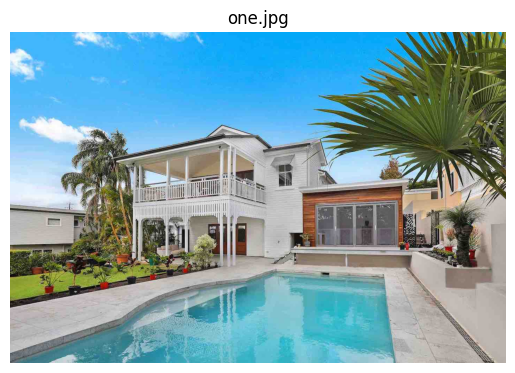

In [ ]:
print(f"Astra DB vector search query: SELECT name, description, item_vector FROM {ASTRA_DB_KEYSPACE}.{ASTRA_DB_TABLE} ORDER BY item_vector ANN OF {text_emb.tolist()} LIMIT 1")
for row in session.execute(f"SELECT name, description, item_vector FROM {ASTRA_DB_KEYSPACE}.{ASTRA_DB_TABLE} ORDER BY item_vector ANN OF {text_emb.tolist()} LIMIT 1"):
    print("\t" + str(row))
    plt.title(row.name)
    image = next(obj for obj in dataset if obj['file'] == row.name)['image']
    plt.imshow(image)
    plt.axis("off")
    plt.show()